# Water Mask
#### Objective: Mapping waterlogged areas during the monsoon season

The monsoon season brings the majority of the annual rainfall to the wet tropical regions of Asia. In a normal year in  Bangladesh, nearly 20% of the country will be underwater after heavy rains and snowmelt cause coastal regions, rivers, and other areas to flood during the June to October monsoon season. 

To examine the changes in water occurance over the region, we'll use both multispectral and Synthetic Aperture Radar (SAR) data available through the DL Platform. Our goal is to produce a snapshot of water coverage using a simple classification method to identify water.

In [1]:
import descarteslabs as dl
import numpy as np
import json
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble

### Find imagery

In selecting classification features to identify water, we will state several assumptions about the spectral response of water relative to other land cover types:

* We expect backscatter over standing water and submerged areas from SAR to be very low in all polarizations.
* We expect NDVI to be low relative to vegetated areas.
* We expect NDWI to be high relative to unsubmerged areas.

We create a tile within Bangladesh, our study region, as a prototype for this demonstration.

In [2]:
lat, lon = 23.7859405, 90.34804269999995

In [3]:
tile = dl.raster.dltile_from_latlon(lat, 
                                    lon, 
                                    resolution = 20.0,
                                    tilesize = 1024,
                                    pad = 0)

In [4]:
avail_scenes, ctx = dl.scenes.search(tile['geometry'],
                    products=["sentinel-2:L1C"],
                    start_datetime='2017-01-01',
                    end_datetime='2017-12-31'
                   )
avail_scenes

SceneCollection of 67 scenes
  * Dates: Jan 02, 2017 to Dec 28, 2017
  * Products: sentinel-2:L1C: 67

### Develop classification model

##### Define classification features to calculate from the imagery

In [5]:
product_dic = {'sentinel-1:GRD': {'bands': ['vv', 'vh'], 'stats': 'min'},
              'sentinel-2:L1C': {'bands': ['ndvi', 'ndwi', 'cloud-mask', 'alpha'], 'stats': 'max'}}

##### Calculate and visualize a sample of the data

In [6]:
date = ['2017-01-01', '2017-01-31']

all_stats = []   
for product in sorted(product_dic.keys()):

    ''' DL Metadata search for imagery over our AOI'''
    
    avail_scenes, ctx = dl.scenes.search(tile['geometry'],
                    products=[product],
                    start_datetime=date[0],
                    end_datetime=date[1]
                   )
   
    ids = avail_scenes.each.properties.id

    bands = product_dic[product]['bands']

    image_stack = None
    for i, idd in enumerate(ids):
        image, meta = dl.raster.ndarray(idd,
                                        bands = bands,
                                        dltile = tile)
    
        if image_stack is None:

            rx = image.shape[0]
            ry = image.shape[1]
            n_images = len(avail_scenes)
            n_bands = 2
            image_stack = np.zeros((n_images, rx, ry, n_bands))

        ''' Mask the clouds '''
        if "cloud-mask" in bands:
            cloud_mask = image[:, :, 2]
            image[cloud_mask == 1] = 0
            image_stack[i, :, :, :] = image[:, :, :2]
            
        else:
            image_stack[i, :, :, :] = image

    
    if product_dic[product]['stats'] == 'min':
        ma = np.ma.masked_equal(image_stack, 0, copy = False)
        all_stats.append(np.ma.min(ma, axis=0))
        
    else:
        all_stats.append(np.max(image_stack, axis = 0)[:, :, :2])

Using the `dl.raster.ndarray` parameters, we can resample and align disparate datasets to the same resolution, projection, and grid alignment. Each of the resulting arrays thus have the same shape and size.

In [7]:
print('Sentinel-1 data shape: {}'.format(all_stats[0].shape))
print('Sentinel-2 data shape: {}'.format(all_stats[1].shape))

Sentinel-1 data shape: (1024, 1024, 2)
Sentinel-2 data shape: (1024, 1024, 2)


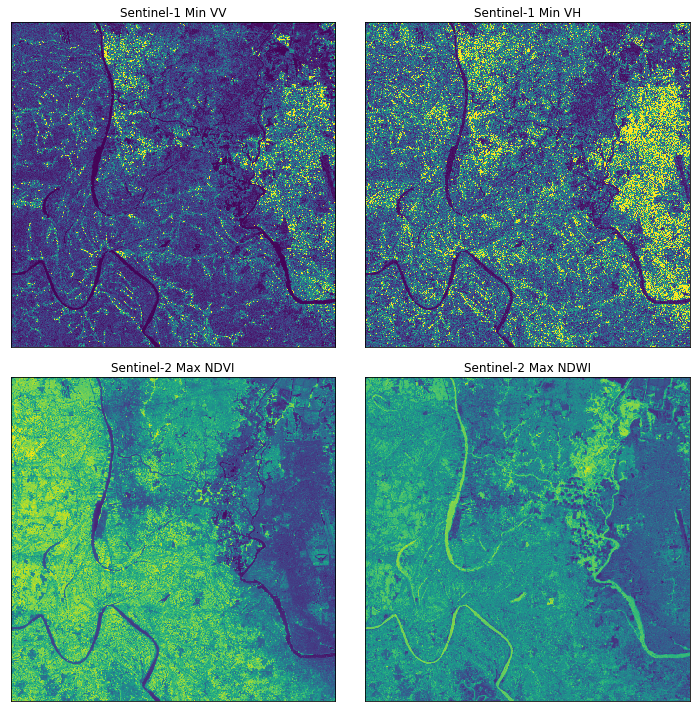

In [8]:
# combine the stats into a single array
all_stats = np.dstack(all_stats).data

fig = plt.figure(figsize=(10,10))
labels = ['Sentinel-1 Min VV', 
         'Sentinel-1 Min VH', 
         'Sentinel-2 Max NDVI',
         'Sentinel-2 Max NDWI']

for i in range(4):
    
    ax = plt.subplot(2, 2, i + 1)
    ax.imshow(all_stats[:, :, i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(labels[i])
    
plt.tight_layout()

#### Build a simple decision rule based on image threshold

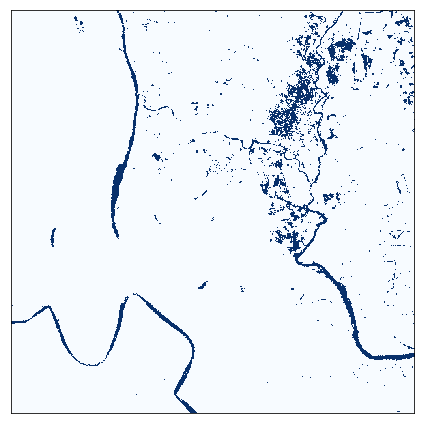

In [9]:
mask = np.where(((all_stats[:, :, 0] < 60) & (all_stats[:, :, 1] < 60)
         & (all_stats[:, :, 2] < 35000) & (all_stats[:, :, 3] > 35000)), 1, 0)

fig = plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='Blues')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

#### Build a simple, supervised machine learning model

Different ways obtain training data using the Descartes Labs Platform:
1. Load existing reference information and extract image data
2. Use an existing Platform product (e.g. Cropland Data Layer) to sample reference data
3. Digitize reference data using Viewer and export as a GeoJSON

In [10]:
with open('water_train.json') as f:
    train_data = json.load(f)

In [11]:
train_features = [[feature['properties']['vv'],
                  feature['properties']['vh'],
                  feature['properties']['ndvi'],
                  feature['properties']['ndwi']] for feature in train_data['features']]

labels = [feature['properties']['class'] for feature in train_data['features']]

le = sklearn.preprocessing.LabelEncoder()
labels = le.fit_transform(labels)

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=10, 
                                              criterion='gini', 
                                              min_samples_split=2, 
                                              min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, 
                                              max_features='auto', 
                                              bootstrap=True, 
                                              n_jobs=1)

clf.fit(train_features, labels)

print('feature importances\n')
for fi, label in zip(clf.feature_importances_, ['vv', 'vh', 'ndvi', 'ndwi']): 
    print("{:<10}: {:5f}".format(label, fi))

feature importances

vv        : 0.381318
vh        : 0.274916
ndvi      : 0.300834
ndwi      : 0.042933


##### Test predictions

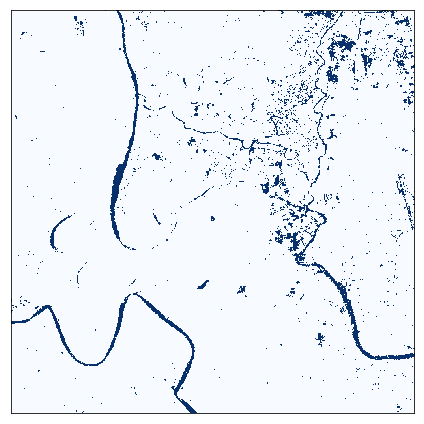

In [12]:
features = all_stats.reshape(all_stats.shape[0]*all_stats.shape[1], all_stats.shape[2])
predictions = clf.predict(features)
predictions = predictions.reshape(all_stats.shape[0], all_stats.shape[1])

fig = plt.figure(figsize=(6,6))
plt.imshow(predictions, cmap='Blues')
plt.xticks([])
plt.yticks([])
plt.tight_layout()